In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from utils.only_img_cus_dataloaders import create_dataloader
from utils.only_img_cus_dataloaders import CustomDataset

In [2]:
def get_img_cropped(center_x, center_y, width, height, img):         
    x1 = int(center_x - width // 2)
    y1 = int(center_y - height // 2)
    
    x2 = int(x1 + width)
    y2 = int(y1 + height)

    cropped_image = img[y1:y2, x1:x2]
    return cropped_image

In [3]:
# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Dataloaders and dataset utils
"""

import contextlib
import glob
import hashlib
import json
import math
import os
import random
import shutil
import time
from itertools import repeat
from multiprocessing.pool import Pool, ThreadPool
from pathlib import Path
from threading import Thread
from urllib.parse import urlparse

import numpy as np
import psutil
import torch
import torch.nn.functional as F
import torchvision
import yaml
from PIL import ExifTags, Image, ImageOps
from torch.utils.data import DataLoader, Dataset, dataloader, distributed
from tqdm import tqdm

from utils.augmentations import (Albumentations, augment_hsv, classify_albumentations, classify_transforms, copy_paste,
                                 letterbox, mixup, random_perspective)
from utils.general import (DATASETS_DIR, LOGGER, NUM_THREADS, TQDM_BAR_FORMAT, check_dataset, check_requirements,
                           check_yaml, clean_str, cv2, is_colab, is_kaggle, segments2boxes, unzip_file, xyn2xy,
                           xywh2xyxy, xywhn2xyxy, xyxy2xywhn)
from utils.torch_utils import torch_distributed_zero_first

# Parameters
HELP_URL = 'See https://docs.ultralytics.com/yolov5/tutorials/train_custom_data'
IMG_FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp', 'pfm'  # include image suffixes
VID_FORMATS = 'asf', 'avi', 'gif', 'm4v', 'mkv', 'mov', 'mp4', 'mpeg', 'mpg', 'ts', 'wmv'  # include video suffixes
LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
PIN_MEMORY = str(os.getenv('PIN_MEMORY', True)).lower() == 'true'  # global pin_memory for dataloaders

# Get orientation exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break



In [152]:
class CustomDataset(Dataset):
    def __init__(self, 
                 path,
                 img_size=640,
                 batch_size=16,
                 augment=False,
                 hyp=None,
                 rect=False,
                 image_weights=False,
                 cache_images=False,
                 single_cls=False,
                 stride=32,
                 pad=0.0,
                 min_items=0,
                 prefix=''):
        self.path = path
        self.im_files = [os.path.join(self.path, filename) for filename in os.listdir(self.path)]
        self.indices = range(len(self.im_files))
        self.img_size = img_size
        # self.batch_size = batch_size
        self.ims = [None] * len(self.im_files)
        self.im_hw0 = [None] * len(self.im_files)
        self.im_hw = [None] * len(self.im_files)
        self.npy_files = []
        self.augment = augment
        self.shapes = np.array([cv2.imread(img_fn).shape[:2] for img_fn in self.im_files])
        self.rect = rect
        
        self.template = cv2.imread('../1_3_crop.tif')
        self.temp_ratio_h, self.temp_ratio_w = self.template.shape[0]/480, self.template.shape[1]/640
        # if isinstance(img_size, list):
        #     reduced_size = (int(img_size.shape[1]*self.temp_ratio_w), int(img_size.shape[0]*self.temp_ratio_h))
        #     self.template = cv2.resize(self.template, reduced_size)
        # if isinstance(img_size, int):
        #     reduced_size = (int(img_size*self.temp_ratio_w), int(img_size*self.temp_ratio_h))
        #     self.template = cv2.resize(self.template, reduced_size)

        

        # Create indices
        n = len(self.shapes)  # number of images
        bi = np.floor(np.arange(n) / batch_size).astype(int)  # batch index
        nb = bi[-1] + 1  # number of batches
        self.batch = bi  # batch index of image
        self.n = n
        self.indices = range(n)

        #labels temp
        dummy_labels = np.random.rand(1, 5)
        dummy_labels[:, 0] = [0.0]
        self.labels = [dummy_labels] * n


        # Rectangular Training
        if self.rect:
            # Sort by aspect ratio
            s = self.shapes  # wh
            ar = s[:, 1] / s[:, 0]  # aspect ratio
            irect = ar.argsort()
            self.im_files = [self.im_files[i] for i in irect]
            self.shapes = s[irect]  # wh
            ar = ar[irect]

            # Set training image shapes
            shapes = [[1, 1]] * nb
            for i in range(nb):
                ari = ar[bi == i]
                mini, maxi = ari.min(), ari.max()
                if maxi < 1:
                    shapes[i] = [maxi, 1]
                elif mini > 1:
                    shapes[i] = [1, 1 / mini]

            self.batch_shapes = np.ceil(np.array(shapes) * img_size / stride + pad).astype(int) * stride
            # print(self.batch_shapes)

            
    def get_img_cropped(self, center_x, center_y, width, height, img):
        x1 = int(center_x - width // 2)
        y1 = int(center_y - height // 2)
        
        x2 = int(x1 + width)
        y2 = int(y1 + height)

        cropped_image = img[y1:y2, x1:x2]
        return cropped_image
    
    def load_image(self, i):
        im, f = self.ims[i], self.im_files[i]
        if im is None:  # not cached in RAM
            im = cv2.imread(f)  # BGR
            assert im is not None, f'Image Not Found {f}'
            h0, w0 = im.shape[:2]  # orig hw
            r = self.img_size / max(h0, w0)  # ratio
            if r != 1:  # if sizes are not equal
                interp = cv2.INTER_LINEAR if (self.augment or r > 1) else cv2.INTER_AREA
                im = cv2.resize(im, (math.ceil(w0 * r), math.ceil(h0 * r)), interpolation=interp)
            return im, (h0, w0), im.shape[:2]  # im, hw_original, hw_resized
        return self.ims[i], self.im_hw0[i], self.im_hw[i]  # im, hw_original, hw_resized
    
    def get_labels(self, main_image, template):

        reduced_size = (int(main_image.shape[1]*self.temp_ratio_w), int(main_image.shape[0]*self.temp_ratio_h))
        template = cv2.resize(template, reduced_size)



        main_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)


        template_width, template_height = template_gray.shape[::-1]


        result = cv2.matchTemplate(main_gray, template_gray, cv2.TM_CCORR_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)


        top_left = max_loc
        bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

        center_x = (bottom_right[0] + top_left[0]) // 2
        center_y = (bottom_right[1] + top_left[1]) // 2

        h = bottom_right[1] - top_left[1]
        w = bottom_right[0] - top_left[0]

        return np.array([[0.0, center_x, center_y, w, h]])

    def __len__(self):
        return len(self.im_files)

    def __getitem__(self, index):

        index_list = [i for i in range(0, len(self.im_files))]
        index_list.remove(index)
        rand_idx = random.choice(index_list)

        index = self.indices[index]  # linear, shuffled, or image_weights
        index1 = self.indices[rand_idx]  # linear, shuffled, or image_weights
        
        

        combined_image = np.zeros((self.img_size, self.img_size, 3))
        combo_shapes = None

        # Load image
        img, (h0, w0), (h, w) = self.load_image(index)
        img1, (h01, w01), (h1, w1) = self.load_image(index1)
        
        print("+_----______________________----------------------")
        print((h01, w01), (h1, w1))
        resize_shape = max(h,w)

        img = cv2.resize(img, (resize_shape, resize_shape))
        img1 = cv2.resize(img1, (resize_shape, resize_shape))
        # return [img, img1]
        # Letterbox
        shape = self.batch_shapes[self.batch[index]] if self.rect else self.img_size  # final letterboxed shape
        img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
        shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling


        shape1 = self.batch_shapes[self.batch[index1]] if self.rect else self.img_size  # final letterboxed shape
        img1, ratio1, pad1 = letterbox(img1, shape1, auto=False, scaleup=self.augment)
        shapes1 = (h01, w01), ((h1 / h01, w1 / w01), pad1)  # for COCO mAP rescaling

        
        labels = self.get_labels(img, self.template)
        labels1 = self.get_labels(img1, self.template)
        
        
        center_x, center_y, width, height = labels[0][1:]
        center_x1, center_y1, width1, height1 = labels1[0][1:]
        
        cropped_img = self.get_img_cropped(center_x, center_y, width, height, img)
        cropped_img1 = self.get_img_cropped(center_x1, center_y1, width1, height1, img1)
        
        # return [cropped_img, cropped_img1]
        new_width = 100
        new_height = 100
        resized_image1 = cv2.resize(cropped_img, (new_width, new_height))
        resized_image2 = cv2.resize(cropped_img1, (new_width, new_height))
        
        ht, wd = img.shape[:2]
        max_img_size = max(ht, wd)
        combined_image = np.ones((ht, wd, 3), dtype=np.uint8) * 255

        paste_x1 = random.randint(0, wd - new_width)
        paste_y1 = random.randint(0, ht - new_height)
        paste_x2 = random.randint(0, wd - new_width)
        paste_y2 = random.randint(0, ht - new_height)

        combined_image[paste_y1:paste_y1+new_height, paste_x1:paste_x1+new_width] = resized_image1
        combined_image[paste_y2:paste_y2+new_height, paste_x2:paste_x2+new_width] = resized_image2
        
        # return [combined_image]
        bottom_right = (paste_x1, paste_y1)
        top_left = (paste_x1+new_width, paste_y1+new_height)

        center_x = (bottom_right[0] + top_left[0]) // 2
        center_y = (bottom_right[1] + top_left[1]) // 2
        


        bottom_right1 = (paste_x2, paste_y2)
        top_left1 = (paste_x2+new_width, paste_y2+new_height)

        center_x1 = (bottom_right1[0] + top_left1[0]) // 2
        center_y1 = (bottom_right1[1] + top_left1[1]) // 2



        self.labels = np.array([[labels[0][0], center_x, center_y, new_width, new_height],
                        [labels1[0][0], center_x1, center_y1, new_width, new_height]])/max_img_size
        self.labels = self.labels.tolist()

        
        labels_main = np.array([[labels[0][0], center_x, center_y, new_width, new_height],
                            [labels1[0][0], center_x1, center_y1, new_width, new_height]])/max_img_size
        
        # return [combined_image, labels_main]
        combo_shape = max(combined_image.shape)#self.img_size  # final letterboxed shape
        combined_image, combo_ratio, combo_pad = letterbox(combined_image, combo_shape, auto=False, scaleup=self.augment)
        combo_h, combo_w, _ = combined_image.shape
        combo_shapes = (combo_h, combo_w), ((combo_h / combo_h, combo_w / combo_w), combo_pad)  # for COCO mAP rescaling
        combined_image = combined_image.astype(np.uint8) 
        
        print(combo_h, combo_w, combo_pad, combo_shape, combo_shapes)
        print(combo_ratio)
        print(h1,w1,h01, w01)
        # return [combined_image, labels_main]
        if labels_main.size:# and labels1.size:  # normalized xywh to pixel xyxy format
            # labels_main[:, 1:] = xywhn2xyxy(labels_main[:, 1:])
            labels_main[:, 1:] = xywhn2xyxy(labels_main[:, 1:], combo_ratio[0] * combo_w, 
                                            combo_ratio[1] * combo_h, padw=combo_pad[0], padh=combo_pad[1])
            # labels1[:, 1:] = xywhn2xyxy(labels1[:, 1:], ratio1[0] * w1, ratio1[1] * h1, padw=pad1[0], padh=pad1[1])
            # print(labels_main)
        
        

        # print("*******************************")
        # print(combined_image)
        nl = len(labels_main)  # number of labels_main
        # nl1 = len(labels1)  # number of labels_main
        if nl:# and nl1:
            labels_main[:, 1:5] = xyxy2xywhn(labels_main[:, 1:5], w=combined_image.shape[1], h=combined_image.shape[0], clip=True, eps=1E-3)
            # print(labels_main)

        # return [combined_image, labels_main]
        labels_out = torch.zeros((nl, 6))
        # labels_out1 = torch.zeros((nl1, 6))
        if nl:# and nl1:
            labels_out[:, 1:] = torch.from_numpy(labels_main)
            # labels_out1[:, 1:] = torch.from_numpy(labels1)

        # Convert
        combined_image = combined_image.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        combined_image = np.ascontiguousarray(combined_image)

        return torch.from_numpy(combined_image), labels_out, self.im_files[index], combo_shapes



In [136]:
dataset = CustomDataset("../images/train/",img_size=1024,batch_size=2)
custom_data = dataset[3]
print(custom_data)

+_----______________________----------------------
(480, 640) (768, 1024)
1024 1024 (0.0, 0.0) 1024 ((1024, 1024), ((1.0, 1.0), (0.0, 0.0)))
(1.0, 1.0)
768 1024 480 640
[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 

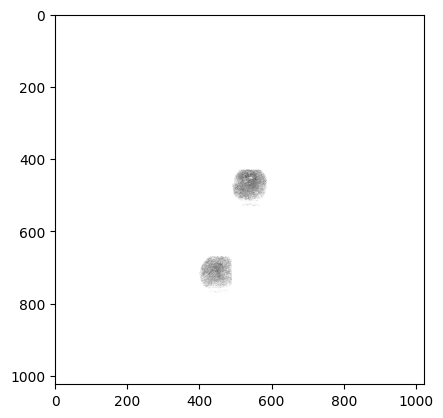

In [137]:
template = cv2.imread('../1_3_crop.tif')
temp_ratio_h, temp_ratio_w = template.shape[0]/480, template.shape[1]/640
main_image = custom_data[0]
plt.imshow(main_image)

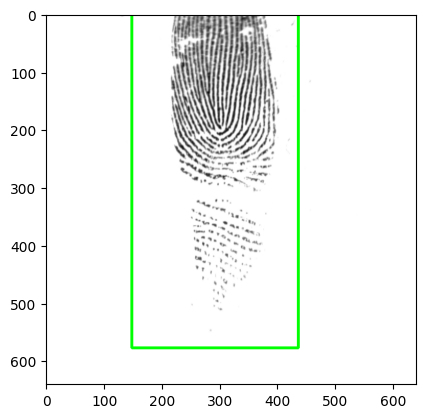

In [17]:
# def get_labels(main_image, template):
def get_labels( main_image, template):
    reduced_size = (int(main_image.shape[1]*temp_ratio_w), int(main_image.shape[0]*temp_ratio_h))
    template = cv2.resize(template, reduced_size)



    main_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)


    template_width, template_height = template_gray.shape[::-1]


    result = cv2.matchTemplate(main_gray, template_gray, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)


    top_left = max_loc
    bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

    center_x = (bottom_right[0] + top_left[0]) // 2
    center_y = (bottom_right[1] + top_left[1]) // 2

    h = bottom_right[1] - top_left[1]
    w = bottom_right[0] - top_left[0]

    # cv2.rectangle(main_image, top_left, bottom_right, (0,255,0), 3)
    # plt.imshow(main_image)
    center_x = (bottom_right[0] + top_left[0]) // 2
    center_y = (bottom_right[1] + top_left[1]) // 2

    h = bottom_right[1] - top_left[1]
    w = bottom_right[0] - top_left[0]

    return np.array([[0.0, center_x, center_y, w, h]])




+_----______________________----------------------
(480, 640) (768, 1024)
1024 1024 (0.0, 0.0) 1024 ((1024, 1024), ((1.0, 1.0), (0.0, 0.0)))
(1.0, 1.0)
768 1024 480 640


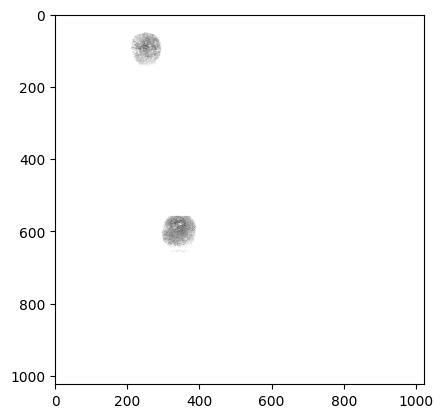

In [149]:
dataset = CustomDataset("../images/train/",img_size=1024,batch_size=2)
custom_data = dataset[3]
main_image = custom_data[0]
plt.imshow(main_image)

In [103]:
# plt.imshow(custom_data[0].permute(1,2,0).numpy())

(292, 559) (392, 659)
(200, 44) (300, 144)


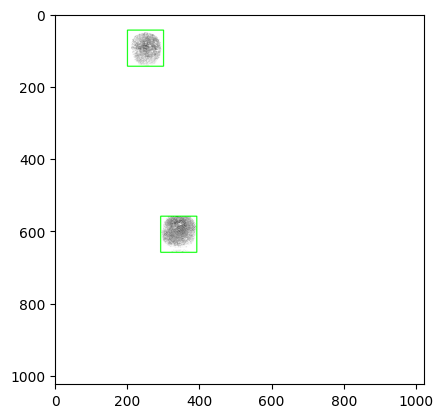

In [150]:

img_viz = custom_data[0].astype(np.uint8).copy()
# plt.imshow(img_viz)
# print(img_viz.shape)
for i in range(custom_data[1].shape[0]):
    center_x, center_y, width, height  = custom_data[1][:,1:][i]*1024
    # x1,y1, x2,y2 = custom_data[1][:,1:][i]

    # print(center_x, center_y, width, height)
    # break
    x1 = int(center_x - width / 2)
    y1 = int(center_y - height / 2)

    x2 = int(center_x + width / 2)
    y2 = int(center_y + height / 2)

    color = (0, 255, 0)  
    thickness = 2  

    print((x1, y1), (x2, y2))

    cv2.rectangle(img_viz, (x1,y1),(x2,y2), color, thickness)
    # cv2.rectangle(img_viz, (int(x1), int((y1))), (int(x2), int(y2)), color, thickness)

plt.imshow(img_viz)


+_----______________________----------------------
(480, 640) (768, 1024)
1024 1024 (0.0, 0.0) 1024 ((1024, 1024), ((1.0, 1.0), (0.0, 0.0)))
(1.0, 1.0)
768 1024 480 640
(183, 33) (283, 133)
(435, 677) (535, 777)


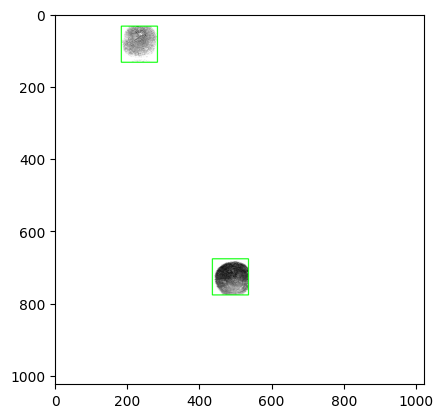

In [3]:
dataset = CustomDataset("../images/train/",img_size=1024,batch_size=2)
custom_data = dataset[3]
img_viz = custom_data[0].permute(1,2,0).numpy().astype(np.uint8).copy()
for i in range(custom_data[1].shape[0]):
    center_x, center_y, width, height  = custom_data[1][:,2:][i].numpy()*1024

    x1 = int(center_x - width / 2)
    y1 = int(center_y - height / 2)

    x2 = int(center_x + width / 2)
    y2 = int(center_y + height / 2)

    color = (0, 255, 0)  
    thickness = 2  

    print((x1, y1), (x2, y2))

    cv2.rectangle(img_viz, (x1, y1), (x2, y2), color, thickness)

    plt.imshow(img_viz)


In [4]:
def get_labels(main_image, template):
    main_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)


    template_width, template_height = template_gray.shape[::-1]


    result = cv2.matchTemplate(main_gray, template_gray, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)


    top_left = max_loc
    bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

    center_x = (bottom_right[0] + top_left[0]) // 2
    center_y = (bottom_right[1] + top_left[1]) // 2

    h = bottom_right[1] - top_left[1]
    w = bottom_right[0] - top_left[0]

    return np.array([[0.0, center_x, center_y, w, h]]), top_left, bottom_right

main_image = custom_data[0]
template_img = custom_data[4]
template_img = cv2.resize(template_img, (int(main_image.shape[1]*temp_ratio_w), int(main_image.shape[0]*temp_ratio_h)))

# print((int(main_image.shape[1]*temp_ratio_w), int(main_image.shape[0]*temp_ratio_h)))
_, top_left, bottom_right = get_labels(main_image, template_img)
cv2.rectangle(main_image, top_left, bottom_right, (0, 0, 255), 2)
plt.imshow(main_image)

IndexError: list index out of range

In [13]:
mh,mw,_ = main_image.shape
mh, mw

img = cv2.imread("/home/somusan/somusan/soumyadip/interview/lens_assignment/yolov5-custom-dataloader/images/train/1_1.tif")
template = cv2.imread("/home/somusan/somusan/soumyadip/interview/lens_assignment/yolov5-custom-dataloader/1_3_crop.tif")

img_h, img_w, _ = img.shape
temp_img_h, temp_img_w, _ = template.shape

temp_ratio_h, temp_ratio_w = temp_img_h/img_h, temp_img_w/img_w


In [23]:
img_h, img_w, 

(480, 640)

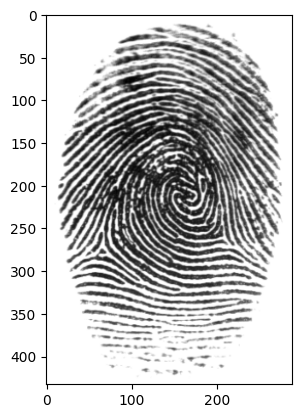

In [6]:
plt.imshow(custom_data[4])
# print(custom_data[0].shape)

In [7]:
img_viz = custom_data[0].permute(1,2,0).numpy().astype(np.uint8).copy()
plt.imshow(img_viz)

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

(533, 358) (595, 405)
(570, 16) (632, 63)


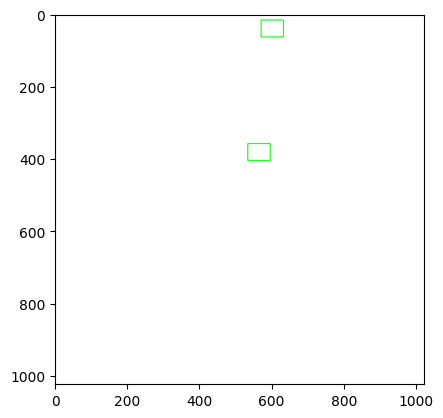

In [ ]:
img_viz = custom_data[0].permute(1,2,0).numpy().astype(np.uint8).copy()
for i in range(custom_data[1].shape[0]):
    center_x, center_y, width, height  = custom_data[1][:,2:][i].numpy()*640

    x1 = int(center_x - width / 2)
    y1 = int(center_y - height / 2)

    x2 = int(center_x + width / 2)
    y2 = int(center_y + height / 2)

    color = (0, 255, 0)  
    thickness = 2  

    print((x1, y1), (x2, y2))

    cv2.rectangle(img_viz, (x1, y1), (x2, y2), color, thickness)

    plt.imshow(img_viz)


In [ ]:
# python yolov5/train.py --img 1024 --batch 2 --epochs 3 --data /home/somusan/somusan/soumyadip/interview/lens_assignment/fingerprint.yaml --weights /home/somusan/somusan/soumyadip/interview/lens_assignment/yolov5/yolov5s.pt

In [ ]:
# python yolov5/train.py --img 1024 --batch 2 --epochs 3 --data /home/somusan/somusan/soumyadip/interview/lens_assignment/fingerprint.yaml --weights /home/somusan/somusan/soumyadip/interview/lens_assignment/yolov5/yolov5s.pt --hyp /home/somusan/somusan/soumyadip/interview/lens_assignment/yolov5/data/hyps/hyp.scratch-low.yaml

In [ ]:
# python yolov5/train.py --img 640 --batch 2 --epochs 3 --data /home/somusan/somusan/soumyadip/interview/lens_assignment/fingerprint.yaml --weights /home/somusan/somusan/soumyadip/interview/lens_assignment/yolov5/yolov5s.pt 

In [ ]:
# python yolov5/train.py --img 640 --batch 2 --epochs 3 --data /home/somusan/somusan/soumyadip/interview/lens_assignment/finger_data/wheat0.yaml --weights /home/somusan/somusan/soumyadip/interview/lens_assignment/yolov5/yolov5s.pt